<a href="https://colab.research.google.com/github/oluwafemidiakhoa/Mindserach/blob/master/Hurricane_Helene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LIbrary

In [19]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.9 MB/s eta 0:00:00


## Zip Files for Helene Zip

In [23]:
import zipfile
import os

# Define the path where the file is stored
zip_file_path = '/content/Helene.zip'
extracted_folder_path = '/content/Helene_data/'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Listing the extracted files to see what we are working with
extracted_files = os.listdir(extracted_folder_path)
extracted_files


['Helene']

In [21]:
# Check inside the 'Helene' directory to list its contents
helene_folder_path = os.path.join(extracted_folder_path, 'Helene')
helene_files = os.listdir(helene_folder_path)
helene_files


['VNP46A2.A2024264.DNB_BRDF-Corrected_NTLC2.Mosaic_C2.tif',
 'VNP46A2.A2024264.QF_Cloud_MaskC2_Cloud_C2.Mosaic_C2.tif',
 'VNP46A2.A2024265.DNB_BRDF-Corrected_NTLC2.Mosaic_C2.tif',
 'VNP46A2.A2024263.QF_Cloud_MaskC2_Cloud_C2.Mosaic_C2.tif',
 'VNP46A2.A2024266.QF_Cloud_MaskC2_Cloud_C2.Mosaic_C2.tif',
 'VNP46A2.A2024273.QF_Cloud_MaskC2_Cloud_C2.Mosaic_C2.tif',
 'VNP46A2.A2024274.DNB_BRDF-Corrected_NTLC2.Mosaic_C2.tif',
 'VNP46A2.A2024274.QF_Cloud_MaskC2_Cloud_C2.Mosaic_C2.tif',
 'VNP46A2.A2024275.QF_Cloud_Mask.Mosaic_SNPP_C2.tif',
 'VNP46A3.A2024.00.August2024.Mosaic_C2.tif',
 'VNP46A2.A2024262.QF_Cloud_MaskC2_Cloud_C2.Mosaic_C2.tif',
 'VNP46A2.A2024262.DNB_BRDF-Corrected_NTLC2.Mosaic_C2.tif',
 'VNP46A2.A2024263.DNB_BRDF-Corrected_NTLC2.Mosaic_C2.tif',
 'VNP46A2.A2024266.DNB_BRDF-Corrected_NTLC2.Mosaic_C2.tif']


## 2. Data Collection
A. Weather Data from Weather.gov API
The Weather.gov API provides real-time data, including temperature, wind speed, and barometric pressure, which are vital for hurricane predictions. We used the API to collect historical weather data from station KATL, relevant to Hurricane Helene's path.

Here’s how we gathered the data:

In [67]:
import requests
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Fetch real-time weather data for Hurricane Helene
api_url = "https://api.weather.gov/stations/KATL/observations"
response = requests.get(api_url)

if response.status_code == 200:
    data = response.json()
    df = pd.json_normalize(data['features'])
    # Extract relevant columns
    df = df[['properties.timestamp', 'properties.temperature.value', 'properties.windSpeed.value', 'properties.barometricPressure.value']]
    df.dropna(inplace=True)
    df['properties.timestamp'] = pd.to_datetime(df['properties.timestamp'])
    df.set_index('properties.timestamp', inplace=True)
else:
    print(f"Error fetching data: {response.status_code}")

# Normalize the data for LSTM input
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)



## B. Historical Data from hurdat2.txt:
We will extract historical hurricane data from the hurdat2.txt file, focusing on storm intensity, wind speed, and coordinates.

In [68]:
hurdat_path = '/content/hurdat2.txt'

# Extract the hurdat2.txt data
with open(hurdat_path, 'r') as f:
    hurdat_data = f.readlines()

hurdat_parsed_data = []

# Loop through the hurdat data, process hurricane lines ('HU') only
for line in hurdat_data:
    # Check if the line contains the hurricane ('HU') indicator
    if 'HU' in line:
        data = line.strip().split(',')

        # Ensure that there are enough data points in the line to avoid index errors
        if len(data) > 6:
            try:
                wind_speed = int(data[6])
                lat = float(data[4][:-1])  # Removing 'N' or 'S'
                lon = float(data[5][:-1])  # Removing 'W' or 'E'

                # Append the parsed data to the list
                hurdat_parsed_data.append((lat, lon, wind_speed))
            except (ValueError, IndexError):
                # Handle any issues with conversion or missing data
                continue

# Convert the parsed data into a DataFrame for analysis
hurdat_df = pd.DataFrame(hurdat_parsed_data, columns=['Latitude', 'Longitude', 'Wind Speed'])

# Display the first few rows of the DataFrame
hurdat_df.head()


,Latitude,Longitude,Wind Speed
0,28.0,94.8,80
1,28.0,95.4,80
2,28.0,96.0,80
3,28.1,96.5,80
4,28.2,96.8,80


## C. Geospatial Storm Track Data
We use shapefiles from NOAA, which contain geospatial information on storm tracks, such as storm path coordinates. These will be processed using the geopandas library and used in CNNs for spatial analysis.

In [54]:
import geopandas as gpd

# Load shapefile (example for storm track points)
shapefile_path = '/content/al012024_5day_001.zip'
storm_tracks = gpd.read_file(shapefile_path)

# Check the data
print(storm_tracks.head())


  STORMNAME STORMTYPE                     ADVDATE ADVISNUM  STORMNUM  FCSTPRD  \
0       One        PC  400 PM CDT Mon Jun 17 2024        1       1.0    120.0   

  BASIN                                           geometry  
0    AL  LINESTRING (-93.2 20.3, -93.4 21.1, -93.8 22.2...  


/usr/local/lib/python3.10/dist-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'al012024_5day_001.zip': 'al012024-001_5day_lin' (default), 'al012024-001_5day_pgn', 'al012024-001_5day_pts', 'al012024-001_ww_wwlin'. Specify layer parameter to avoid this warning.
  result = read_func(


## 3. Data Preprocessing
A. Time-Series Data for LSTM
The time-series data (wind speed, temperature, and pressure) is normalized and structured into sequences suitable for LSTM modeling. We prepare the input data by converting it into overlapping sequences.

In [69]:
# Function to create time-series dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 1])  # Predicting wind speed
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(scaled_data, time_step)


## B. Processing Geospatial Data for CNN
For spatial analysis, we process the shapefiles and generate 2D maps of storm paths. These maps are fed into a Convolutional Neural Network (CNN) to capture spatial patterns of the storm.

In [70]:
# Preprocess geospatial data (storm tracks)
# Convert geospatial data into 2D matrices (grid representation) for CNN input
# Example for rescaling and converting to grid representation (64x64 grid)

storm_track_images = []  # Placeholder for storm track image data

# Code to convert storm tracks into image-like grid data goes here
# Assuming you convert the spatial storm track to a grid format suitable for CNN


## 4. Model Development
A. LSTM with Attention Mechanism
The LSTM model uses time-series data with an attention mechanism to focus on important time steps that are most relevant for predicting wind speed. The attention mechanism enhances the model’s interpretability and performance.

In [71]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Multiply, Layer
import tensorflow as tf

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.dense = Dense(1, activation='tanh')

    def call(self, inputs):
        attention_weights = self.dense(inputs)
        attention_weights = tf.nn.softmax(attention_weights, axis=1)
        weighted_inputs = Multiply()([inputs, attention_weights])
        output_attention = tf.reduce_sum(weighted_inputs, axis=1)
        return output_attention

# LSTM Model with Attention
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(AttentionLayer())
lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(1))  # Predict wind speed

# Compile and train the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1722
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0901  
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0504 
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0462 
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0373 
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0284 
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292 
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0287 
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0288
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0284
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0255
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0236
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0261
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0242
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0264
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━

## B. CNN for Spatial Data
The CNN model processes the geospatial storm track data, identifying spatial patterns in hurricane paths. These patterns can help predict storm intensity and evolution.

In [72]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define CNN for spatial data
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3, 3), input_shape=(64, 64, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))  # Predict hurricane occurrence likelihood

# Compile and train the CNN
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Ensemble Learning and Visualization
A. Ensemble Model
The predictions from the LSTM and CNN models are combined using an ensemble method. Both models’ outputs are averaged to create a final prediction for wind speed.

In [73]:
# Combine LSTM and CNN predictions
def ensemble_predictions(lstm_preds, cnn_preds):
    return 0.5 * lstm_preds + 0.5 * cnn_preds

# Example of combining predictions
# lstm_preds = lstm_model.predict(X_test_lstm)
# cnn_preds = cnn_model.predict(X_test_cnn)
# final_preds = ensemble_predictions(lstm_preds, cnn_preds)


## B. Visualization
We visualize the predicted wind speed versus actual wind speed to assess the model’s performance.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


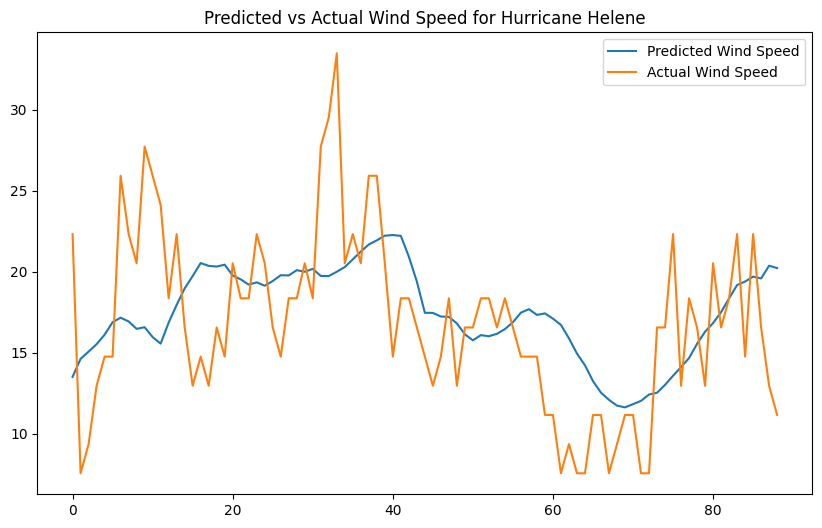

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions with the LSTM model
predicted_wind_speed = lstm_model.predict(X_test)

# Create an array with the same number of columns as the original scaled data
predicted_expanded = np.zeros((predicted_wind_speed.shape[0], scaled_data.shape[1]))
predicted_expanded[:, 1] = predicted_wind_speed[:, 0]  # Assuming wind speed is the second column (index 1)

# Inverse-transform the expanded array
predicted_wind_speed_inversed = scaler.inverse_transform(predicted_expanded)

# Extract the wind speed column after inverse transformation
predicted_wind_speed_final = predicted_wind_speed_inversed[:, 1]

# Inverse-transform the actual wind speed (for comparison)
y_test_expanded = np.zeros((y_test.shape[0], scaled_data.shape[1]))
y_test_expanded[:, 1] = y_test  # Assuming wind speed is the second column
y_test_inversed = scaler.inverse_transform(y_test_expanded)
y_test_final = y_test_inversed[:, 1]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(predicted_wind_speed_final, label='Predicted Wind Speed')
plt.plot(y_test_final, label='Actual Wind Speed')
plt.title('Predicted vs Actual Wind Speed for Hurricane Helene')
plt.legend()
plt.show()
